<a href="https://colab.research.google.com/github/Vince-O-lab/TReND-CaMinA/blob/main/Copy_of_Cosyne_BWM_tutorial_notebook_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture output
! pip install ibllib
! pip install pynapple
! pip install git+https://github.com/int-brain-lab/paper-brain-wide-map.git
! pip install -U google-colab

In [ ]:
# system
from pathlib import Path
from tqdm import tqdm
import pickle

# analysis
import numpy as np
import pandas as pd
import pynapple as nap

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# set the IBL style for figures
from ibl_style.style import figure_style
figure_style()

# Accessing the IBL brainwide map dataset

[Companion Slides Here](https://docs.google.com/presentation/d/1hLR4_Yyuv11QsxAuBertRARs3qvncl9-NApt0vmqmsk/edit#slide=id.p1)

The IBL brainwide map dataset ([biorxiv preprint](https://www.biorxiv.org/content/10.1101/2023.07.04.547681v2)) consists of more that 62k units, distributed over the entire brain, recorded from over 100 mice in over 400 sessions. It is publicly accessible via `ONE`.

## A minimal `ONE` primer
`ONE` is the _Open Neurophysiology Environment_, a framework for accessing and sharing data acquired in neurophysiology experiments.

+ [main documentation and tutorial](https://int-brain-lab.github.io/ONE/one_reference.html)

+ [in depth colab notebook](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7)

+ [github repository](https://github.com/int-brain-lab/ONE)

### `ONE` and `Alyx`
`ONE` works on top of `Alyx`, a relational database that hosts and relates all experimental metadata, as well as links to the storage location of the individual datasets.

+ [main documentation](https://alyx.readthedocs.io/en/latest/index.html)

+ [github repository](https://github.com/cortex-lab/alyx)

For this tutorial, we will work mostly with objects and access function that make most of the functionality available in simple and abstracted ways.

## Configuring and instantiating `ONE`
The `ONE` object can be instantiated in many different ways to work in different modes (online / local), you can find more information here [here](https://int-brain-lab.github.io/ONE/one_installation.html)

In [ ]:
from one.api import ONE

one_kwargs = dict(
    base_url='https://openalyx.internationalbrainlab.org',
    username='intbrainlab',
    password='international',
    silent=True,
)
one = ONE(**one_kwargs)

## Essential concepts for working with `ONE`

### Concept: experiment id (`eid`), probe id (`pid`) and probe name

+ Each experiment has it's own and unique id, and all data that is associated to that experiment can by accessed by using this id, in code often abbreviated by `eid`.

+ Each inserted probe has a `pid`. For a dual neuropixel recording, there are thus two `pid` associated to one `eid`. Like the `eid`, a `pid` is a unique identifier.

+ Each inserted probe has a name, which is always an `probe00` or `probe01`.

These ids and names can be converted into each other with `one.eid2pid()` and `one.pid2eid()` and we will need to use both to access the data from the IBL brainwide map.

In [ ]:
# this is just an example eid
# we will see how to get eids in a moment further down
eid = "c7bd79c9-c47e-4ea5-aea3-74dda991b48e"

pids, pnames = one.eid2pid(eid)
print(pids, pnames)

[UUID('675952a4-e8b3-4e82-a179-cc970d5a8b01'), UUID('79f44ba1-c931-4346-82eb-f628a9374045')] ['probe01', 'probe00']


In [ ]:
pid = pids[0]
eid, pname = one.pid2eid(pid)
print(eid, pname)

c7bd79c9-c47e-4ea5-aea3-74dda991b48e probe01


## Getting `eid`s for the brainwide map dataset
The brainwide map dataset is just a fraction of the data that can be openly accessed via `ONE`. See [here](https://int-brain-lab.github.io/ONE/notebooks/one_search/one_search.html) for some more in depth guide on how to search for datasets openly accesible via `ONE`.

A great way to have an interactive overview of the datasets is to visit the IBL viz app here:
[viz.internationalbrainlab.org/app](https://viz.internationalbrainlab.org/app?spikesorting=ss_2024-05-06)


To get the full table of the brainwide map dataset programmatically, one can use the summary tables present in the module `brainwidemap`
[github repository](https://github.com/int-brain-lab/paper-brain-wide-map)


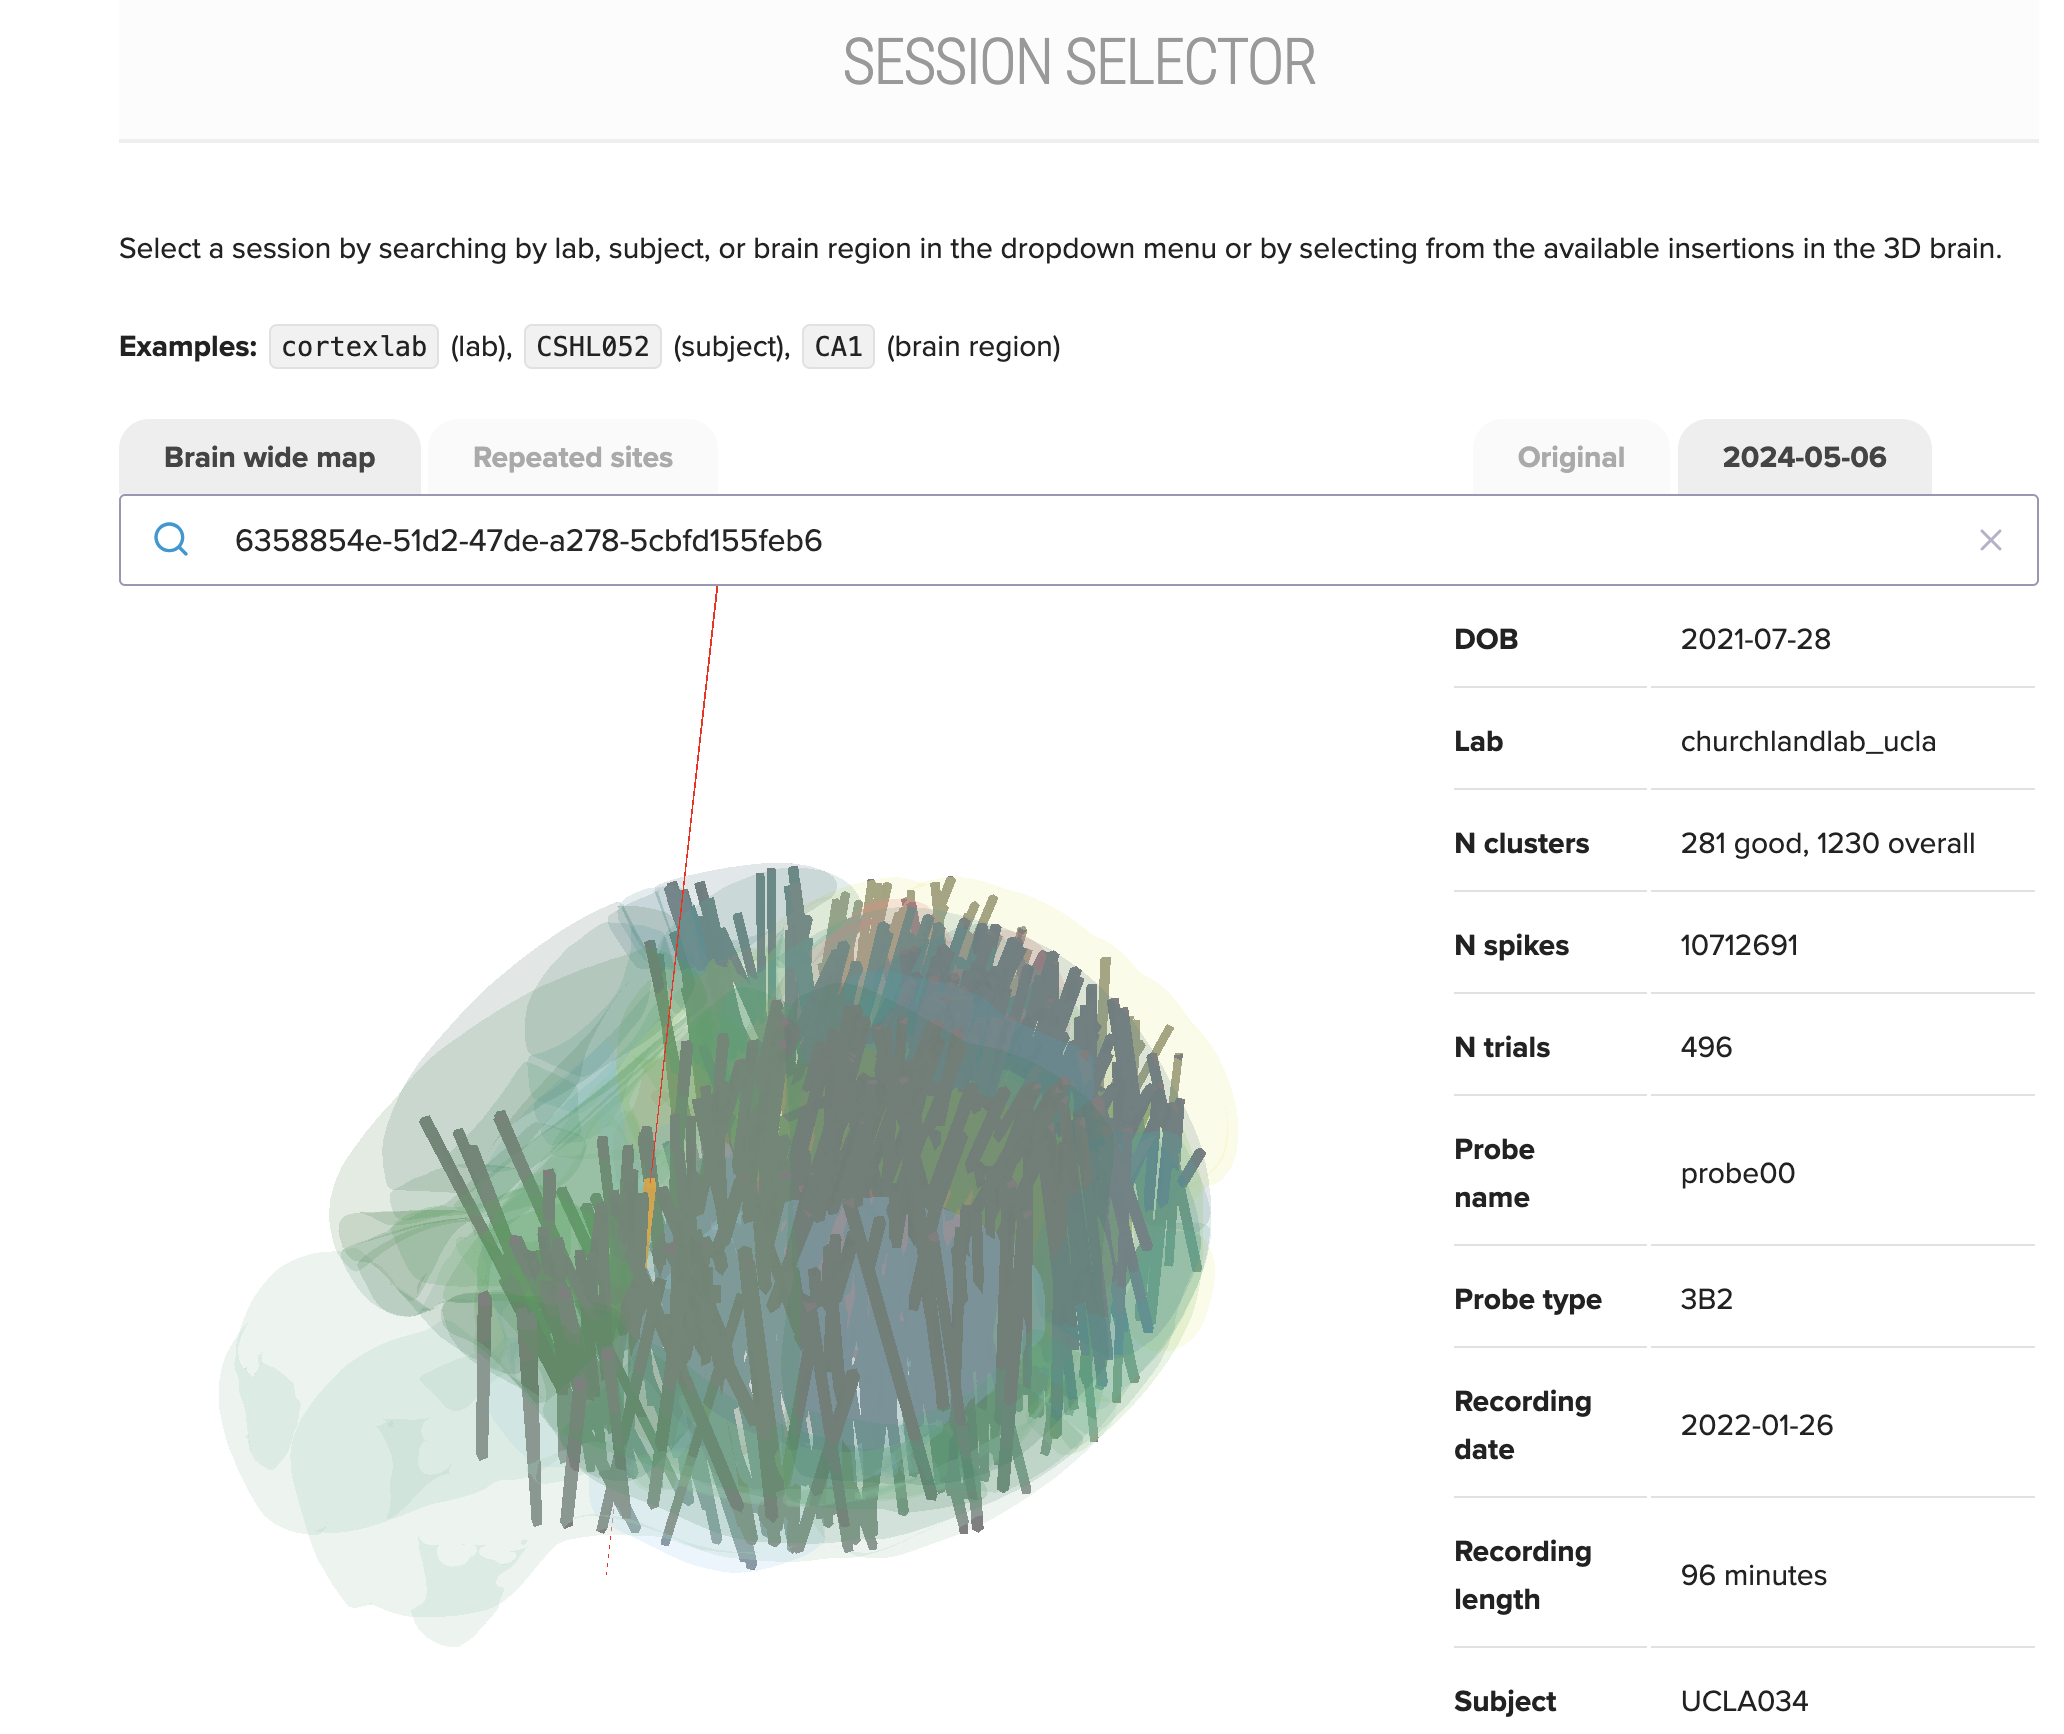


In [ ]:
import brainwidemap
# this dataframe holds a summary of all the sessions
# and for us importantly, the eids and pids
bwm_df = brainwidemap.bwm_query()  # each row of this dataframe is a recording

n_sessions = bwm_df["eid"].unique().shape[0]
n_insertions = bwm_df["pid"].unique().shape[0]
print(
    f"{n_sessions} sessions with {n_insertions} individual neuropixel recordings"
)
bwm_df.head()

Loading bwm_query results from fixtures/2023_12_bwm_release.csv
459 sessions with 699 individual neuropixel recordings


,pid,eid,probe_name,session_number,date,subject,lab
0,56f2a378-78d2-4132-b3c8-8c1ba82be598,6713a4a7-faed-4df2-acab-ee4e63326f8d,probe00,1,2020-02-18,NYU-11,angelakilab
1,47be9ae4-290f-46ab-b047-952bc3a1a509,56956777-dca5-468c-87cb-78150432cc57,probe01,1,2020-02-21,NYU-11,angelakilab
2,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,56956777-dca5-468c-87cb-78150432cc57,probe00,1,2020-02-21,NYU-11,angelakilab
3,8dfb86c8-d45c-46c4-90ec-33078014d434,4364a246-f8d7-4ce7-ba23-a098104b96e4,probe01,1,2020-01-20,NYU-12,angelakilab
4,c893c0a3-5597-49cf-baa1-60efdfdef542,b182b754-3c3e-4942-8144-6ee790926b58,probe01,1,2020-01-21,NYU-12,angelakilab


## Getting units from the brainwide map

Likewise, another helper function gives you access to all the units in the brainwide map. This table gathers a lot of important metadata:
+ brain region and localization
+ single cell quality metrics
+ `eid` and `pid` of the recording

In [ ]:
units_df = brainwidemap.bwm_units(one)
n_units = units_df.shape[0]
print(f"{n_units} units present in the table")
units_df

Loading bwm_query results from fixtures/2023_12_bwm_release.csv


(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/bwm_tables/trials.pqt: 100%|██████████| 24.2M/24.2M [00:00<00:00, 26.6MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/bwm_tables/clusters.pqt: 100%|██████████| 91.6M/91.6M [00:04<00:00, 21.9MB/s]


d16d0b38d392b18c0ce8b615ec89d60d7c901df2eeb3432986b62130af28ef01
62990 units present in the table


,Beryl,eid,channels,depths,uuids,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,...,ks2_label,x,y,z,acronym,atlas_id,axial_um,lateral_um,pid,spike_count_good
0,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,61,620.0,c5cabbda-1f74-4168-ad5e-7c5a2f533d9f,79,0.000300,0.000081,0.000158,1.056608,...,good,-0.002378,-0.000250,-0.006350,CNU,23,620.0,11.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,167762.0
1,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,68,700.0,5b5176f2-228f-46b5-85c8-205cf9d90a53,88,0.000323,0.000123,0.000221,0.972567,...,good,-0.002364,-0.000250,-0.006272,CNU,23,700.0,43.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,16139.0
2,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,71,720.0,19930b44-2f8a-44e1-a8ce-46184f7334cb,91,0.000187,0.000057,0.000109,1.266665,...,good,-0.002364,-0.000250,-0.006252,CNU,23,720.0,27.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,34700.0
3,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,77,780.0,304c2251-f207-4926-ba28-967ebbda4473,105,0.000208,0.000046,0.000079,1.655816,...,good,-0.002364,-0.000250,-0.006192,CNU,23,780.0,11.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,224475.0
4,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,82,840.0,4bd714b8-5753-4561-87e5-2ef3126426b7,115,0.000346,0.000085,0.000163,1.334542,...,good,-0.002364,-0.000250,-0.006132,CNU,23,840.0,59.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,292062.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62985,x,810b1e07-009e-4ebe-930a-915e4cd8ece4,55,560.0,3beabe91-423a-49c3-8e55-fb846457c89d,152,0.000258,0.000093,0.000139,1.890024,...,good,-0.001714,-0.006287,-0.004645,HB,765,560.0,27.0,c5fd185f-1c5a-4aad-9795-43c4ccf8ea94,2307.0
62986,x,810b1e07-009e-4ebe-930a-915e4cd8ece4,57,580.0,78952ffb-d419-464e-96e9-2b22723aa58b,158,0.000910,0.000085,0.000170,3.049439,...,good,-0.001725,-0.006281,-0.004621,HB,765,580.0,11.0,c5fd185f-1c5a-4aad-9795-43c4ccf8ea94,544566.0
62987,x,810b1e07-009e-4ebe-930a-915e4cd8ece4,54,560.0,2490ff61-baae-4e8e-a90e-d34e851b8cd1,160,0.000213,0.000069,0.000119,1.654493,...,good,-0.001714,-0.006287,-0.004645,HB,765,560.0,59.0,c5fd185f-1c5a-4aad-9795-43c4ccf8ea94,37240.0
62988,x,810b1e07-009e-4ebe-930a-915e4cd8ece4,58,600.0,945e9b3b-0a09-4272-b56e-7640e1e1f647,161,0.000247,0.000070,0.000109,1.398105,...,good,-0.001735,-0.006276,-0.004598,HB,765,600.0,59.0,c5fd185f-1c5a-4aad-9795-43c4ccf8ea94,37519.0


## Example: loading a recording with spikes from a given brain region

Lets get a recording where the probe was inserted into our favourite brain area. The simplest way is to access the 'Beryl' column of the `units_df` dataframe and use it to select units

In [ ]:
units_df['Beryl'].unique()

array(['AAA', 'ACAd', 'ACAv', 'ACB', 'AD', 'AId', 'AIp', 'AIv', 'AM',
       'ANcr1', 'ANcr2', 'AON', 'APN', 'APr', 'AUDd', 'AUDp', 'AUDpo',
       'AUDv', 'AV', 'BLA', 'BMA', 'BST', 'CA1', 'CA2', 'CA3', 'CEA',
       'CENT2', 'CENT3', 'CL', 'CLA', 'CLI', 'CM', 'COAp', 'COPY', 'CP',
       'CS', 'CU', 'CUL4 5', 'CUN', 'DCO', 'DEC', 'DG', 'DN', 'DP', 'DR',
       'ECT', 'ECU', 'ENTl', 'ENTm', 'EPd', 'EPv', 'Eth', 'FC', 'FL',
       'FOTU', 'FRP', 'FS', 'GPe', 'GPi', 'GRN', 'GU', 'HATA', 'I5', 'IA',
       'IAD', 'IC', 'ICB', 'IGL', 'ILA', 'IP', 'IRN', 'LA', 'LAV', 'LD',
       'LDT', 'LGd', 'LGv', 'LH', 'LHA', 'LING', 'LP', 'LPO', 'LRN',
       'LSc', 'LSr', 'LSv', 'MA', 'MARN', 'MD', 'MDRN', 'MEA', 'MG', 'MH',
       'MOB', 'MOp', 'MOs', 'MPO', 'MRN', 'MS', 'MV', 'NB', 'NDB', 'NLL',
       'NOD', 'NOT', 'NPC', 'NTS', 'OP', 'ORBl', 'ORBm', 'ORBvl', 'OT',
       'P5', 'PA', 'PAA', 'PAG', 'PAR', 'PARN', 'PB', 'PBG', 'PC5', 'PCG',
       'PCN', 'PF', 'PFL', 'PGRN', 'PH', 'PIR', 'PL', 'PO',

The column `Beryl` denotes brain atlas annotations without layer sub-divisions or certain ganglial/nucleus sub-devisisions (e.g. the core/shell sub-division of the lateral geniculate nucleus). Fibre tracts, pia, etc. are also absent.

However, there are many other ways to group brain areas. The Allen CCF defines a brain region hierarchy:



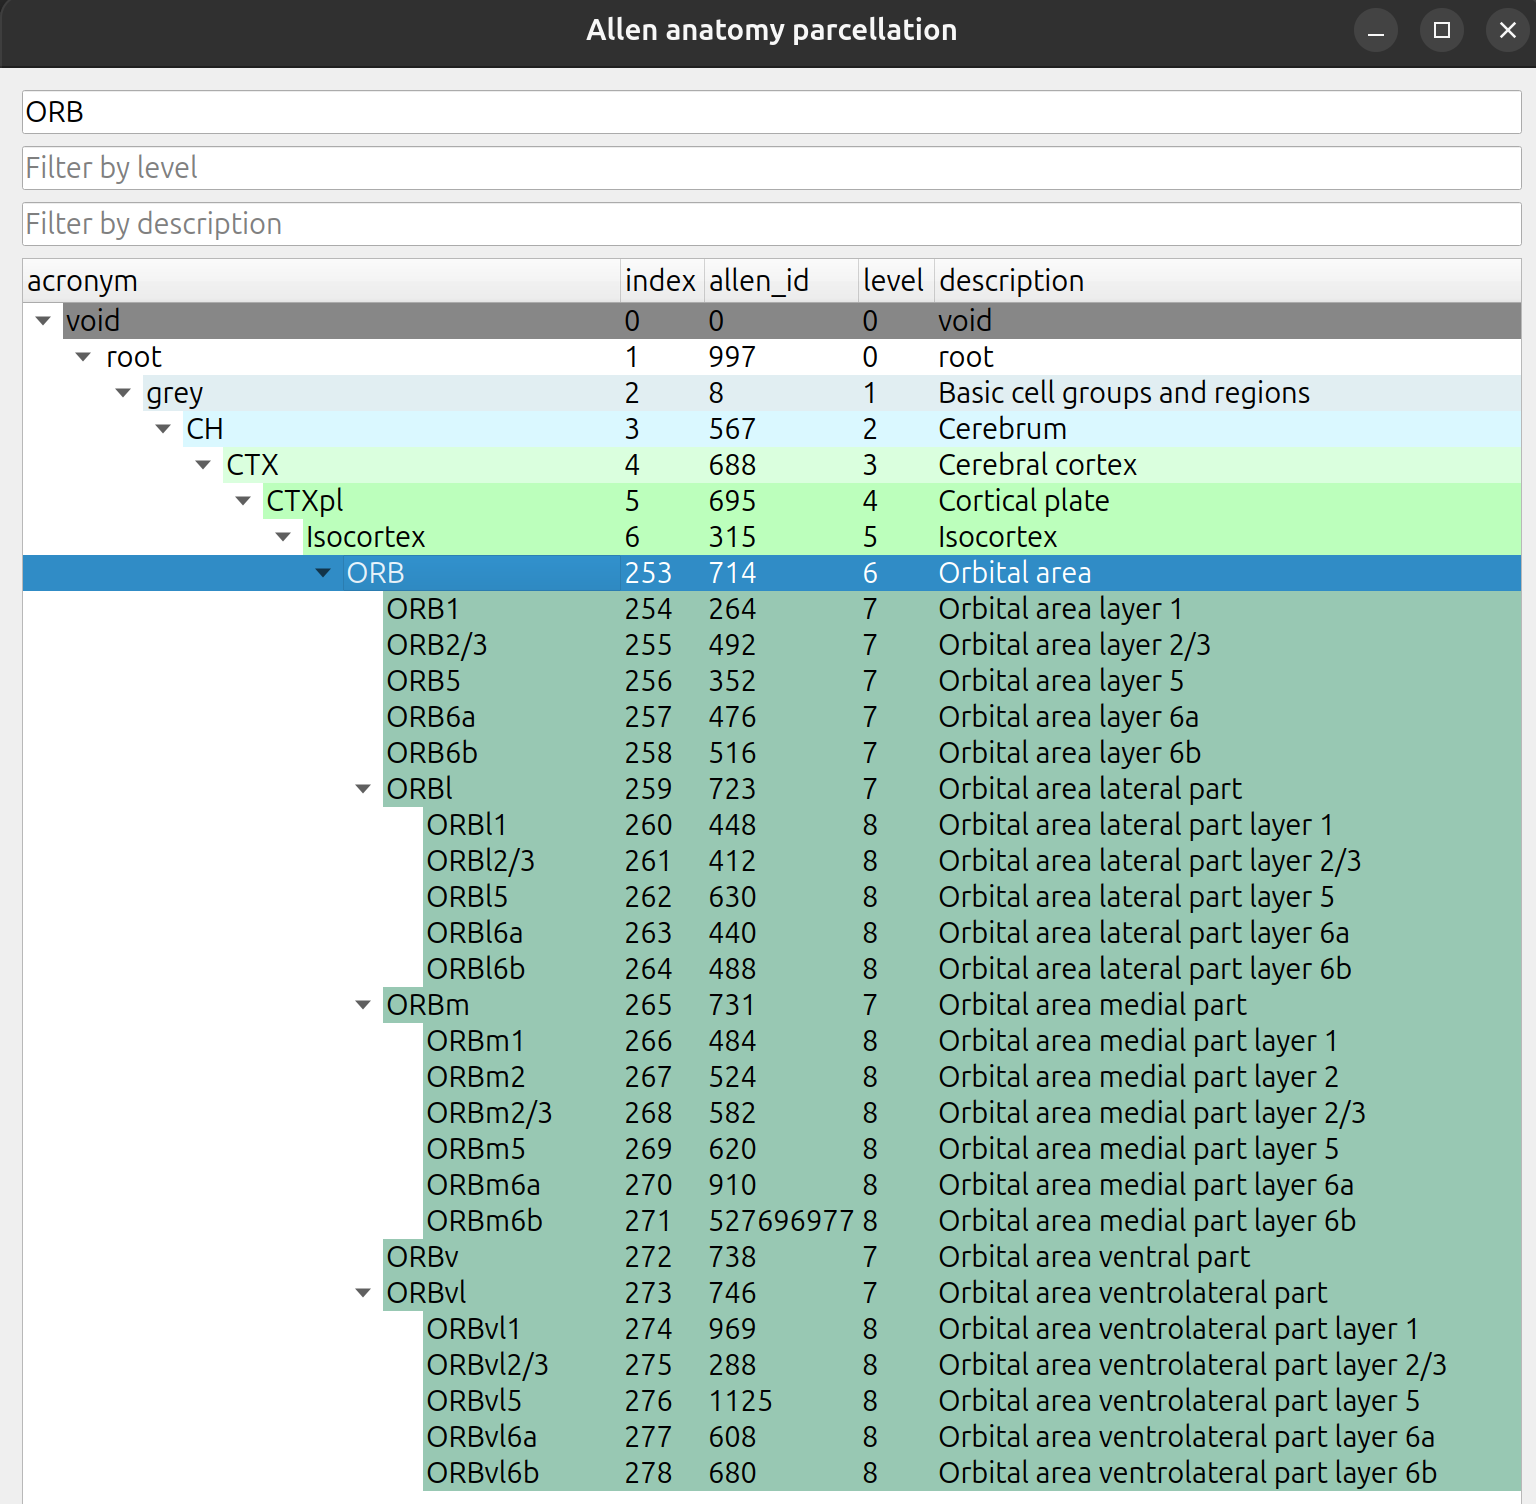

The module `iblatlas` offers access functions for navigating this hierachy.

+ [Documentation](https://int-brain-lab.github.io/iblenv/_autosummary/iblatlas.html)

+ [Examples](https://int-brain-lab.github.io/iblenv/notebooks_external/atlas_working_with_ibllib_atlas.html)

+ [Github repository](https://github.com/int-brain-lab/iblatlas)



In [ ]:
area = "ORB"
from iblatlas.atlas import BrainRegions
regions = BrainRegions()

# convert acronym to Allen unique atlas id
atlas_id = regions.acronym2id(acronym=area)

# get all the ids of descendant brain areas
atlas_ids = regions.descendants(atlas_id)['id']

# a boolean vector to index
ix = units_df['atlas_id'].isin(atlas_ids)

units_df_ = units_df.loc[ix]
print(f"{units_df_.shape[0]} units for brain area {area}")

1178 units for brain area ORB


## Loading data using the `SessionLoader` and `SpikeSortingLoader` (preview)

There are two main helper classes that are the recommended way for loading all the data associated to a single session. The `SessionLoader` for all behavioral data, and the `SpikeSortingLoader` for all the electrophysiological data.

In [ ]:
from brainbox.io.one import SessionLoader, SpikeSortingLoader

# working with this recording for the following example
pid = "ad315779-2b39-46c4-8348-b166e796fa7c"
pid = units_df_["pid"].unique()[0]
eid, pname = one.pid2eid(pid)

session_loader = SessionLoader(one=one, eid=eid)
session_loader.load_trials()
trials = session_loader.trials
trials

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_trials.table.pqt: 100%|██████████| 46.8k/46.8k [00:00<00:00, 211kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.55k/4.55k [00:00<00:00, 6.85kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.55k/4.55k [00:00<00:00, 45.6kB/s]


,goCueTrigger_times,stimOff_times,contrastLeft,response_times,stimOn_times,goCue_times,firstMovement_times,probabilityLeft,feedback_times,contrastRight,rewardVolume,feedbackType,choice,intervals_0,intervals_1
0,92.899239,95.582767,1.0000,94.506751,92.899033,92.900067,93.235267,0.5,94.506867,NaN,1.5,1.0,1.0,92.205833,96.082765
1,98.761390,105.331867,0.1250,103.247636,98.761267,98.762367,98.649267,0.5,103.248667,NaN,0.0,-1.0,-1.0,96.474067,105.831965
2,108.277682,109.915933,1.0000,108.832286,108.277500,108.278333,108.435267,0.5,108.832367,NaN,1.5,1.0,1.0,106.208467,110.415999
3,111.644509,113.132300,NaN,112.049513,111.644400,111.645300,111.872267,0.5,112.049600,0.0625,1.5,1.0,-1.0,110.796200,113.632332
4,114.911133,116.294300,0.2500,115.238733,114.911000,114.911967,114.981267,0.5,115.238833,NaN,1.5,1.0,1.0,113.999633,116.794335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,3321.135904,3381.034933,0.1250,3378.968603,3320.723533,3321.136867,3377.540267,0.8,3378.969633,NaN,0.0,-1.0,-1.0,3320.646900,3381.535027
549,3383.173039,3443.250700,0.0625,3443.174669,3383.172900,3383.173967,NaN,0.8,3443.175733,NaN,0.0,-1.0,0.0,3382.517533,3445.674693
550,3447.184205,3507.070867,NaN,3505.000603,3446.721700,3447.184967,3504.082267,0.2,3505.001633,0.2500,0.0,-1.0,1.0,3446.640900,3507.570926
551,3509.066838,3570.819933,NaN,3569.068355,3509.066667,3509.067633,NaN,0.2,3569.069300,0.0000,0.0,-1.0,0.0,3508.546833,3571.568378


This is the trials table summarizing the information of each trial of the session. We will go into more detail about this in the following section of this tutorial.

In [ ]:
# get pid for eid
pids, pnames = one.eid2pid(eid)
# instantiating the spike sorting loader with the pid
spike_sorting_loader = SpikeSortingLoader(one=one, pid=pid)
# passing good_units=True will only load units that pass stringent quality metrics
spikes, clusters, channels = spike_sorting_loader.load_spike_sorting(good_units=True)

Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_25.nrrd Bytes: 32998960


100%|██████████| 31.470260620117188/31.470260620117188 [00:00<00:00, 120.32it/s]


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/annotation_25.nrrd Bytes: 4035363


100%|██████████| 3.848422050476074/3.848422050476074 [00:00<00:00, 29.56it/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/#2024-05-06#/passingSpikes.table.pqt: 100%|██████████| 98.3M/98.3M [00:01<00:00, 56.8MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/#2024-05-06#/clusters.channels.npy: 100%|██████████| 8.08k/8.08k [00:00<00:00, 70.1kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/#2024-05-06#/clusters.depths.npy: 100%|██████████| 4.10k/4.10k [00:00<00:00, 37.9kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/#2024-05-06#/clusters.metrics.pqt: 100%|██████████| 137k/137k [00:00<00:00, 438kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainla

# Behavior

## Behavior - example 1) plotting a psychometric from the trials table

Lets select an `eid` and use the the SessionLoader to load the trials table. The trials table is a `pd.DataFrame` which contains:

+ time stamps for trial events (such as stimulus onset, or time of reward delivery)

+ categorical data (for example choice (left/right) and outcome (rewarded/unrewarded), or current block)


In [ ]:
bwm_eids = bwm_df["eid"].unique()
eid = bwm_eids[1]

session_loader = SessionLoader(eid=eid, one=one)
session_loader.load_trials()

# trials as dataframe
trials = session_loader.trials

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-11/2020-02-21/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.9k/37.9k [00:00<00:00, 321kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-11/2020-02-21/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.53k/3.53k [00:00<00:00, 37.7kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-11/2020-02-21/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.53k/3.53k [00:00<00:00, 37.5kB/s]


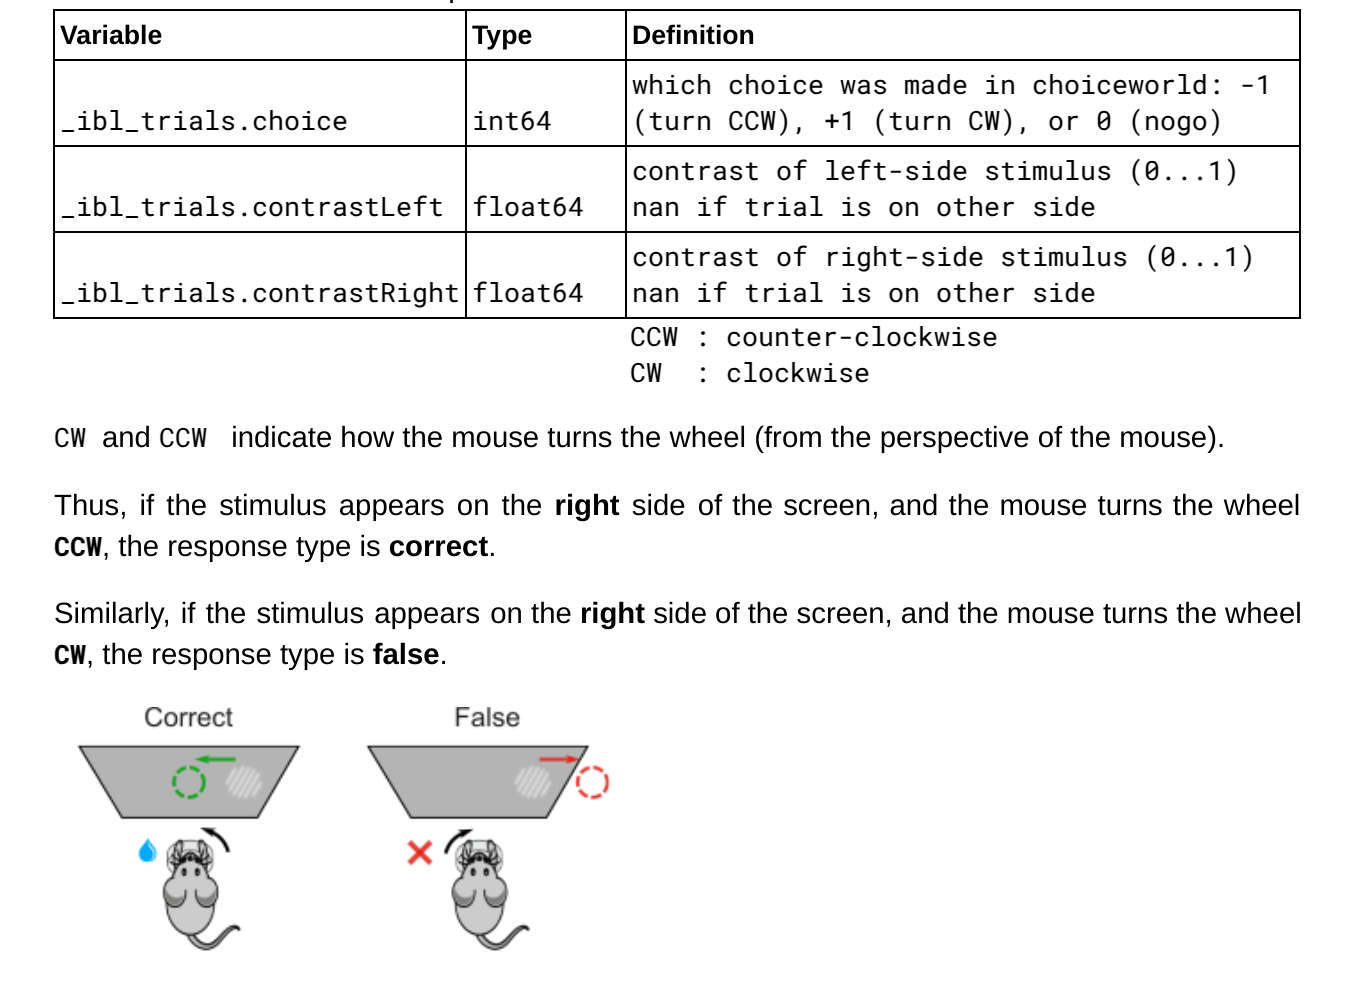

see this document for an in depth description of all the entries in the trials table: [link](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit?tab=t.0)

We are going to calculate the animals psychometric curve and see if it changes as a function of the probability on which side the stimulus appears.

The psychometric in this case will be defined as the fraction of rightward choices as a function of contrast. We expect the very high left and right contrasts to be very informative and the fraction of the correct trials to be high.

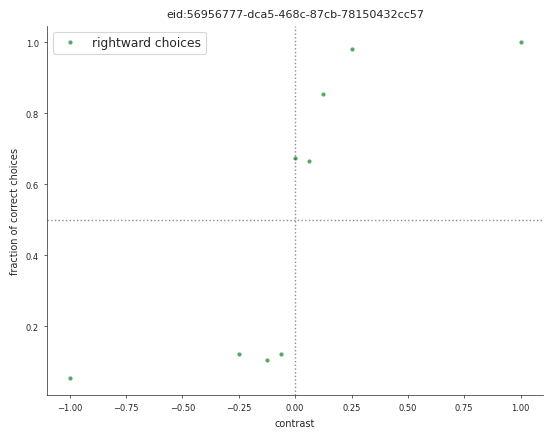

In [ ]:
# we convert the contrast values from two columns into a
# single (signed) value for convenience
# for signed contrast: negative values define stimulus appears on the left
trials["contrast"] = -1 * trials["contrastLeft"]
ix = trials["contrastLeft"].isna()
trials.loc[ix, "contrast"] = trials.loc[ix, "contrastRight"]

# fraction of correct choices
# feedbackType = 1: correct, feedbackType = -1 : incorrect
f_correct = {}
for contrast, group in trials.groupby("contrast"):
    f_correct[contrast] = np.sum(group["feedbackType"] == 1) / group.shape[0]

# to make sure that they are in ascending order for the plot
contrasts = np.sort(trials["contrast"].unique())
f_correct = np.array([f_correct[contrast] for contrast in contrasts])

# converting correct to rightward choice
f_right = f_correct
f_right[contrasts < 0] = 1 - f_right[contrasts < 0]

fig, axes = plt.subplots()
axes.plot(contrasts, f_right, ".", color="g", label="rightward choices")
axes.legend()
axes.set_xlabel("contrast")
axes.set_ylabel("fraction of correct choices")
axes.set_title(f"eid:{eid}")
axes.axhline(0.5, linestyle=':',linewidth=1,color='k',alpha=.5)
axes.axvline(0, linestyle=':',linewidth=1,color='k',alpha=.5)
sns.despine(fig)

lets fit a logistic function to the values of the psychometric curve. We include lapse rates. Note that this is a very simplistic way of doing so. If you are interested in a more in depth discussion of lapse rates and fitting psychometric curves, check out this paper:

_Mice alternate between discrete strategies during perceptual decision-making_
[Ashwood et al. (2022), Nat Neurosci](https://www.nature.com/articles/s41593-021-01007-z)

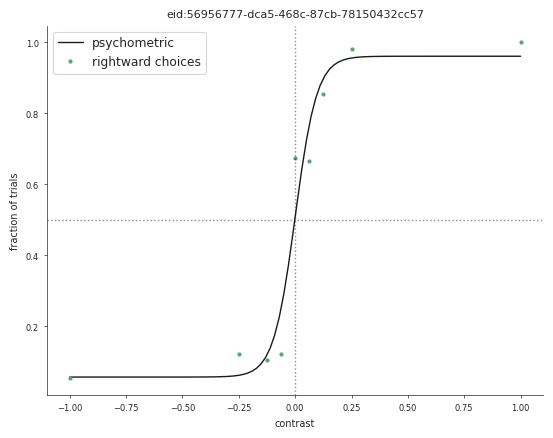

In [ ]:
from scipy.optimize import curve_fit


def psychometric_w_lapses(x, x0, k, Lu, Ll):
    # a sigmoid with additional free parameters for
    # upper and lower offset captureing the lapses
    return Lu / (1 + np.exp(-k * (x - x0))) + Ll


def get_psychometric(x, y):
    # helper function for the fit
    p0 = (0, 10, 0, 1)
    bounds = ((-1, 1), (-np.inf, np.inf), (0, 1), (-1, 1))
    pfit = curve_fit(psychometric_w_lapses, x, y, p0, bounds=np.array(bounds).T)[0]
    x_fit = np.linspace(x.min(), x.max(), 100)
    return x_fit, psychometric_w_lapses(x_fit, *pfit)


fig, axes = plt.subplots()
axes.plot(*get_psychometric(contrasts, f_right), lw=1, color="k", label="psychometric")
axes.plot(contrasts, f_right, ".", color="g", label="rightward choices")
axes.legend()
axes.set_xlabel("contrast")
axes.set_ylabel("fraction of trials")
axes.set_title(f"eid:{eid}")
axes.axhline(0.5, linestyle=':',linewidth=1,color='k',alpha=.5)
axes.axvline(0, linestyle=':',linewidth=1,color='k',alpha=.5)
sns.despine(fig)


Let's repeat this analysis, but this time subdivide the session into periods of different blocks. We use the values in `trials['probabilityLeft']` to infer block identity.

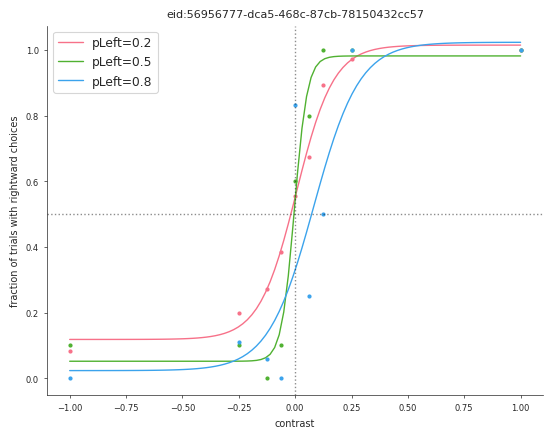

In [ ]:
# the probability of the stimulus appearing on the left side
# defines the block identity.
block_ps = np.sort(trials["probabilityLeft"].unique())

# and we iterate over all possible block combinations
f_correct = {}
for (contrast, p_block), group in trials.groupby(["contrast", "probabilityLeft"]):
    f_correct[contrast, p_block] = np.sum(group["feedbackType"] == 1) / group.shape[0]

# defining colors for plotting
block_colors = dict(zip(block_ps, sns.color_palette("husl", n_colors=3)))

fig, axes = plt.subplots()
for p in block_ps:
    fs = np.array([f_correct[contrast, p] for contrast in contrasts])
    f_right = fs[contrasts < 0] = 1 - fs[contrasts < 0]
    axes.plot(contrasts, fs, ".", color=block_colors[p])
    axes.plot(
        *get_psychometric(contrasts, fs), color=block_colors[p], label=f"pLeft={p}"
    )

axes.legend()
axes.set_xlabel("contrast")
axes.set_ylabel("fraction of trials with rightward choices")
axes.set_title(f"eid:{eid}")
axes.axhline(0.5, linestyle=':',linewidth=1,color='k',alpha=.5)
axes.axvline(0, linestyle=':',linewidth=1,color='k',alpha=.5)
sns.despine(fig)



## Behavior - example 2) analysis of individual differences in wheel kinematics

Mice show different individual movement patterns when turning the wheel. We want to analyse the individual differences.

### reading wheel data with the `SessionLoader`
Just like loading the trials table, we use a `.load` function:

In [ ]:
session_loader.load_wheel()
wheel_df = session_loader.wheel
wheel_df

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-11/2020-02-21/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.97M/4.97M [00:00<00:00, 11.0MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-11/2020-02-21/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.97M/4.97M [00:00<00:00, 14.5MB/s]


,times,position,velocity,acceleration
0,0.013056,-0.001534,0.000000,0.000000
1,0.014056,-0.001318,0.218578,218.577637
2,0.015056,-0.001102,0.218869,0.291086
3,0.016056,-0.000886,0.218763,-0.105821
4,0.017056,-0.000670,0.218265,-0.498161
...,...,...,...,...
3770425,3770.437988,-67.212799,-0.002383,0.416614
3770426,3770.438965,-67.212822,-0.002011,0.371735
3770427,3770.439941,-67.212837,-0.001682,0.328933
3770428,3770.441162,-67.212860,-0.001393,0.288511


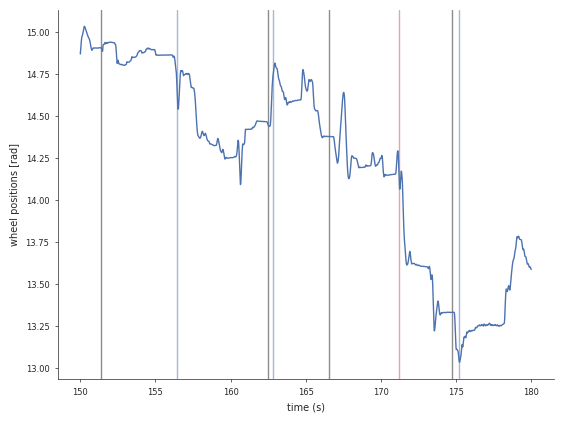

In [ ]:
# we convert the dataframe into a pynapple object (TsdFrame)
wheel_tf = nap.TsdFrame(wheel_df.set_index("times"))

# pynapple objects are very convienient for data analysis
# very similar to pd.DataFrames, but for explicilty for time series
# with a lot of helper functions for neuroscience

# lets plot the entire wheel trace over a time segment
t_start = 150
t_stop = t_start + 30
# selecting trials that start after t_start and end before t_stop
trial_ix = np.logical_and(
    trials["intervals_0"] > t_start, trials["intervals_1"] < t_stop
)
trials_ = trials.loc[trial_ix]

# pynapple objects can be sliced in time with interval sets
wheel_tf_ = wheel_tf.restrict(nap.IntervalSet(t_start, t_stop))

fig, axes = plt.subplots()
# we plot all stimulus onset times and outcomes
for t in trials_["stimOn_times"]:
    axes.axvline(t, color="k", alpha=.5)

outcome_colors = {1: "b", -1: "r"}
for outcome, group in trials_.groupby("feedbackType"):
    for t in group["feedback_times"]:
        axes.axvline(t, color=outcome_colors[outcome], alpha=.5)

axes.plot(wheel_tf_["position"])
axes.set_xlabel("time (s)")
axes.set_ylabel("wheel positions [rad]")
sns.despine(fig)

Let's analyze across all mice (=sessions) in the brainwide map dataset. First we get alll the wheel movements for all correct rightwards trials, 1 second before the mice clock in their choice:

Because this takes ~1h to run, we provide you with the output as a pickle file here:


In [ ]:
## don't run this cell in this tutorial ##
colab = True

if not colab:
  # a local folder to store the results intermediately
  base_folder = Path.home() / "data_local" / "bwm_wheel"

  # this will be our event of interest
  align_event = "response_times"

  # for each session in the brainwide map
  for eid in tqdm(bwm_eids):
      # 1) we load the session as above
      session_loader = SessionLoader(eid=eid, one=one)
      session_loader.load_wheel()
      session_loader.load_trials()

      trials = session_loader.trials
      wheel_df = session_loader.wheel
      wheel = nap.TsdFrame(wheel_df.set_index("times"))

      # 2) slicing into 1s before the mice hit the target
      # just for this demo: only successful rightward trials
      trials_ = trials.groupby(["choice", "feedbackType"]).get_group((-1, 1))

      # 3) we use a pynapple timeseries to compute a peri-event histogram
      times = nap.Ts(t=trials_[align_event].values)
      peri = nap.compute_perievent(wheel["velocity"], times, (-.5, 0))
      outpath = base_folder / f"{eid}-{align_event}.pkl"

      outpath.parent.mkdir(exist_ok=True, parents=True)

      # 4) we dump the data locally
      with open(outpath, "wb") as fH:
          pickle.dump(peri, fH)

In [ ]:
# loading this data from disk after computation
# you only need to run this if you run the cell above locally

if not colab:
  base_folder = Path.home() / "data_local" / "bwm_wheel"
  align_event = "response_times"
  velocities = {}
  for eid in tqdm(bwm_df["eid"].unique()):
      with open(base_folder / f"{eid}-{align_event}.pkl", "rb") as fH:
          velocities[eid] = pickle.load(fH)

  # because of rounding errors, we might miss or gain a sample at the end of
  # the period we shave one off here for simplicity for this tutorial, in a real
  # world application one would take more care ;)

  n_samples = 499
  n_sessions = bwm_eids.shape[0]
  velocities_avg = np.zeros((n_sessions, n_samples))

  for i, eid in enumerate(tqdm(bwm_eids)):
      # we get the peri-event data
      peri = velocities[eid]
      # stack it into a numpy average, and average across trials
      velocities_ = np.stack([p.d[:n_samples] for _, p in peri.items()], axis=0)
      velocities_avg[i] = np.average(velocities_, axis=0)

  tvec = np.linspace(-1, 0, n_samples)

  outpath = base_folder / "velocities_average.pkl"
  with open(outpath, "wb") as fH:
      pickle.dump(velocities_avg, fH)

in the context of this tutorial, we provide you with the result of the above computation. Run this following cell to download the result

In [ ]:
import requests
import pickle
import numpy as np

# URL of the pickle file to download
url = 'https://ibl-brain-wide-map-public.s3.amazonaws.com/sample_data/Cosyne2025/velocities_average.pkl'
response = requests.get(url)

# download file locally
with open('downloaded_file.pkl', 'wb') as file:
    file.write(response.content)

# open file and unpickle
with open('downloaded_file.pkl', 'rb') as file:
    velocities_avg = pickle.load(file)

n_samples = 499
tvec = np.linspace(-.5, 0, n_samples)

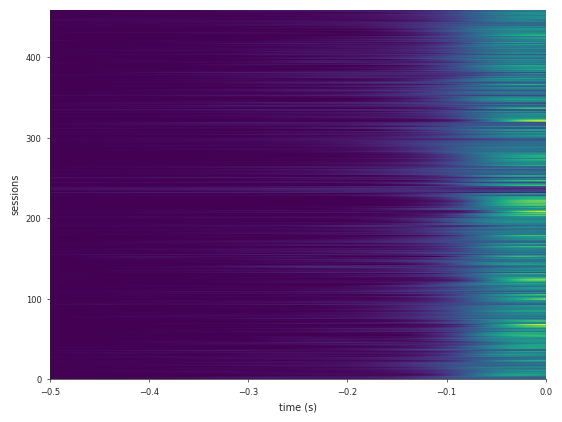

In [ ]:
# inspect the resulting matrix
fig, axes = plt.subplots()

extent = (tvec[0], tvec[-1], 0, n_sessions)
axes.matshow(velocities_avg, vmin=0, extent=extent, cmap='viridis')
axes.set_aspect("auto")

axes.set_ylabel("sessions")
axes.set_xlabel("time (s)")

import matplotlib.ticker as ticker
axes.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
axes.xaxis.set_ticks_position('bottom')



In order to approximate the number of different behavioral strategies, we run k-means clustering of the above matrix and analyze the silhouette scores (link)

100%|██████████| 10/10 [00:01<00:00,  7.53it/s]
<ipython-input-22-2eb7b8d4a3af>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(clusters)


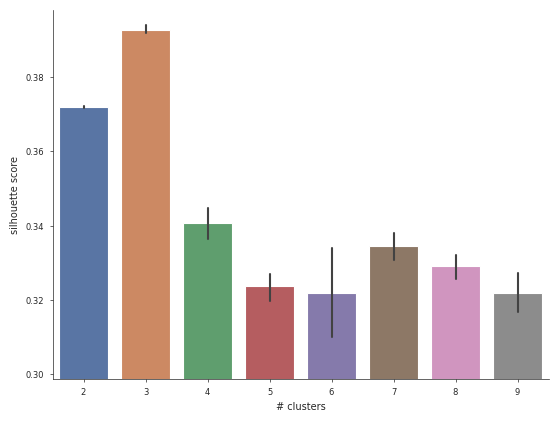

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

# we scale our data to have maximal differences in last .1s
# (when we expect the most variance)
X = MinMaxScaler().fit_transform(velocities_avg[:, 400:])

# we run k-means 10 times
N = 10
clusters = range(2, 10)
scores = np.ndarray((N, len(clusters)))
for i in tqdm(range(N)):
    for j, k in enumerate(clusters):
        kmeans = KMeans(n_clusters=k)
        labels = kmeans.fit_predict(X)
        scores[i, j] = silhouette_score(X, labels)

# and inspect the result
from seaborn import barplot

fig, axes = plt.subplots()
barplot(data=scores, ax=axes)
axes.set_ylim(*np.percentile(scores, (0.1, 99.9)))
axes.set_xticklabels(clusters)
axes.set_ylabel("silhouette score")
axes.set_xlabel("# clusters")
sns.despine(fig)

this suggests 3 different clusters ~ 3 behavioral movement types. Note that this is a fairly simple approach to analyze this rather complex question, and a proper analysis could for example include unsupervised clustering of more data than just the wheel movement

149 for 0
229 for 1
81 for 2


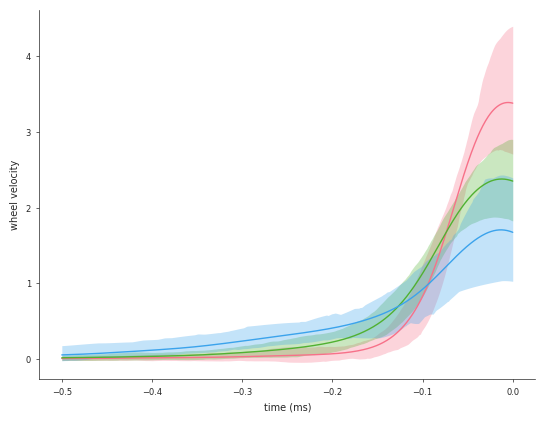

In [ ]:
# we repeat k-means for 3 clusters and plot the differences
n_clusters = 3

# scaling the input and clustering
X = MinMaxScaler().fit_transform(velocities_avg)
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(X)

cluster_colors = dict(zip(np.unique(labels), sns.color_palette("husl", n_colors=n_clusters)))

# plot the average trace for each cluster and it's confidence interval
fig, axes = plt.subplots()
for label in set(labels):
    data = velocities_avg[labels == label, :]
    print(f"{data.shape[0]} for {label}")
    # the average trace
    axes.plot(tvec, np.average(data, axis=0), color=cluster_colors[label])
    # the confidence interval
    axes.fill_between(
        tvec,
        *np.percentile(data, (5, 95), axis=0),
        color=cluster_colors[label],
        linewidth=0,
        alpha=0.3,
    )
    axes.set_ylabel("wheel velocity")
    axes.set_xlabel("time (ms)")
sns.despine(fig)

Text(0.5, 0, 'time (s)')

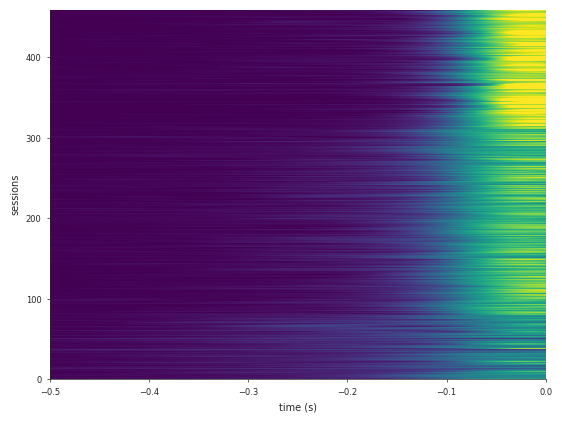

In [ ]:
# plot the matrix, sorted to cluster
order = np.argsort(labels)
fig, axes = plt.subplots()

extent = (tvec[0], tvec[-1], 0, n_sessions)
vmax = np.percentile(velocities_avg, 99)
axes.matshow(velocities_avg[order, :], vmin=0, vmax=vmax, extent=extent, cmap='viridis')
axes.xaxis.set_ticks_position('bottom')
axes.set_aspect("auto")
axes.set_ylabel("sessions")
axes.set_xlabel("time (s)")


## Other behavioral data: video

+ pose estimation (currently deeplabcut, soon: lightningpose [github](https://github.com/int-brain-lab/iblvideo))

+ pupil diameter

+ lick times

+ motion energy

pose estimation from video (DLC), licks, pupil, moption energy

In [ ]:
eid = bwm_eids[0]
session_loader.load_pose(views=["right"])
pose_df = session_loader.pose["rightCamera"]
pose_df

/usr/local/lib/python3.11/dist-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-11/2020-02-21/001/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 81.8M/81.8M [00:01<00:00, 66.3MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-11/2020-02-21/001/alf/#2023-04-20#/_ibl_rightCamera.times.npy: 100%|██████████| 4.36M/4.36M [00:00<00:00, 18.3MB/s]


,times,nose_tip_x,nose_tip_y,nose_tip_likelihood,pupil_top_r_x,pupil_top_r_y,pupil_top_r_likelihood,pupil_right_r_x,pupil_right_r_y,pupil_right_r_likelihood,...,tube_top_likelihood,tube_bottom_x,tube_bottom_y,tube_bottom_likelihood,tongue_end_l_x,tongue_end_l_y,tongue_end_l_likelihood,tongue_end_r_x,tongue_end_r_y,tongue_end_r_likelihood
0,128.489800,494.834705,118.133125,1.0,NaN,NaN,0.866181,NaN,NaN,0.299294,...,0.362505,NaN,NaN,0.007442,NaN,NaN,0.007443,NaN,NaN,0.008717
1,128.496424,494.513489,118.254496,1.0,NaN,NaN,0.802198,NaN,NaN,0.325833,...,0.273784,NaN,NaN,0.005433,NaN,NaN,0.004905,NaN,NaN,0.007526
2,128.503048,493.774460,118.254496,1.0,NaN,NaN,0.787186,NaN,NaN,0.557635,...,0.280121,NaN,NaN,0.004371,NaN,NaN,0.001648,NaN,NaN,0.003982
3,128.509672,493.184622,118.133125,1.0,NaN,NaN,0.803087,NaN,NaN,0.358511,...,0.594829,NaN,NaN,0.004706,NaN,NaN,0.001722,NaN,NaN,0.003137
4,128.516392,493.184622,117.268631,1.0,NaN,NaN,0.154359,NaN,NaN,0.176854,...,0.782376,NaN,NaN,0.014754,NaN,NaN,0.008964,NaN,NaN,0.015376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544934,3751.529756,491.764473,114.959673,1.0,NaN,NaN,0.695250,NaN,NaN,0.375954,...,0.939649,NaN,NaN,0.496684,NaN,NaN,0.000603,NaN,NaN,0.000242
544935,3751.536380,491.761591,114.962322,1.0,NaN,NaN,0.713264,NaN,NaN,0.342186,...,0.939162,NaN,NaN,0.497847,NaN,NaN,0.000605,NaN,NaN,0.000244
544936,3751.543004,491.750732,114.962322,1.0,NaN,NaN,0.710006,NaN,NaN,0.321303,...,0.937239,NaN,NaN,0.491369,NaN,NaN,0.000605,NaN,NaN,0.000244
544937,3751.549724,491.750732,114.959673,1.0,NaN,NaN,0.723959,NaN,NaN,0.287735,...,0.937601,NaN,NaN,0.492664,NaN,NaN,0.000605,NaN,NaN,0.000237


# Spike trains analysis

In this example we will look at insertions within the Anterior Cingulate Cortex, and display the activity of one Unit.

We will look at raster maps for each trial, centered on the stimulus onset, for different task conditions:


*   Absolute contrast: 0%, 6.25%, 12.5% 25% and 100%
*   Trial outcome: correct / incorrect

The first step is to define helper functions


In [ ]:
# Here we repeat the imports and instantiate ONE, so this cell can also be run stand-alone
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

from iblutil.numerical import bincount2D
from iblatlas.atlas import BrainRegions
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader, SessionLoader
from ibl_style.style import figure_style

figure_style()  # set the style for IBL figures

one_kwargs = dict(
    base_url='https://openalyx.internationalbrainlab.org',
    username='intbrainlab',
    password='international',
    silent=True,
)
one = ONE(**one_kwargs)

def psth_indices(times, t_events, fs=None, event_window=np.array([-1, 1])):
    """
    Compute the peri-event time indices
    :param signal:
    :param times:
    :param t_events:
    :param fs:
    :param event_window:
    :return: idx_psth: (nc, nt), tscale
    """
    event_window = np.array(event_window)
    if fs is None:
        fs = 1 / np.nanmedian(np.diff(times))
    # compute a vector of indices corresponding to the perievent window at the given sampling rate
    sample_window = np.round(
        np.arange(event_window[0] * fs, event_window[1] * fs + 1)
    ).astype(int)
    # we inflate this vector to a 2d array where each column corresponds to an event
    idx_psth = np.tile(sample_window[:, np.newaxis], (1, t_events.size))
    # we add the index of each event too their respective column
    idx_event = np.searchsorted(times, t_events)
    idx_psth += idx_event
    # here we handle the case where the event window is outside of the initial boundaries
    i_out_of_bounds = np.logical_or(idx_psth > (times.size - 1), idx_psth < 0)
    idx_psth[i_out_of_bounds] = -1
    return idx_psth, sample_window.astype(float) / fs


def compute_binned_psths(st, sc, t_events, dt=0.02, event_window=np.array([-1, 1])):
    raster, t_scale, c_scale = bincount2D(st, sc, xbin=dt)
    ipsth, tscale = psth_indices(t_scale, t_events=t_events, event_window=event_window)
    return raster[:, ipsth], tscale  # (nc, nt, ne)


## Querying and loading the data

Then we will query the brain region ACA. ACA has many sub-regions, and we need to get the list of neurons belinging to any of the sub-regions.

In [ ]:
# Here we perform the brain region query on ACA.
pids = one.search_insertions(atlas_acronym='ACA', datasets='spikes.times.npy', project='brainwide')
regions = BrainRegions()
aca_leaf_nodes = regions.descendants(regions.acronym2id('ACA'))
print(f"List of regions to query: \n {aca_leaf_nodes['acronym']}")


List of regions to query: 
 ['ACA' 'ACA1' 'ACA2/3' 'ACA5' 'ACA6a' 'ACA6b' 'ACAd' 'ACAd1' 'ACAd2/3'
 'ACAd5' 'ACAd6a' 'ACAd6b' 'ACAv' 'ACAv1' 'ACAv2/3' 'ACAv5' 'ACAv6a'
 'ACAv6b']


In [ ]:
# We will display a window of -1 / +1 secs around the Stimulus Onset
event_window = [-1, 1]
pid =pids[9]

# Here we load the spikes and the trials has we have seen before. Here we load only the units passing the quality control
ssl = SpikeSortingLoader(one=one, pid=pid)
spikes, clusters, channels = ssl.load_spike_sorting(good_units=True, revision='2025-05-26')
df_clus = pd.DataFrame(ssl.merge_clusters(spikes, clusters, channels))
sl = SessionLoader(one=one, eid=ssl.eid)
sl.load_trials()
# For the trials, it is handy to create a column that contains the absolute contrast
sl.trials['ucontrast'] = np.nanmean(np.stack((sl.trials['contrastLeft'], sl.trials['contrastRight'])), axis=0)

# This is were we select the units belonging to any of the leaf nodes brain regions
selection_clusters = df_clus['atlas_id'].isin(aca_leaf_nodes['id'])
iclusters = np.where(selection_clusters)[0]
# We extend the selection to the spikes that belong to the selected clusters
ispikes = np.isin(spikes['clusters'], iclusters)
st = spikes['times'][ispikes]
sc = spikes['clusters'][ispikes]
# We compute the PSTHs
psths, tscale = compute_binned_psths(st, sc, t_events=sl.trials['stimOn_times'].values, event_window=event_window)  # (nc, nt, ne)


(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-04/001/alf/probe00/pykilosort/#2024-05-06#/passingSpikes.table.pqt: 100%|██████████| 33.4M/33.4M [00:00<00:00, 46.7MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-04/001/alf/probe00/pykilosort/#2024-05-06#/clusters.channels.npy: 100%|██████████| 3.51k/3.51k [00:00<00:00, 20.7kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-04/001/alf/probe00/pykilosort/#2024-05-06#/clusters.depths.npy: 100%|██████████| 1.82k/1.82k [00:00<00:00, 12.6kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-04/001/alf/probe00/pykilosort/#2024-05-06#/clusters.metrics.pqt: 100%|██████████| 66.7k/66.7k [00:00<00:00, 448kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-04/001/alf/probe00/pykilosort/#2024-05-06#/clusters.uuids.csv

## Display a raster plot aligned to Stimulus Onset

Here we will select a unit and display a few raster plot.

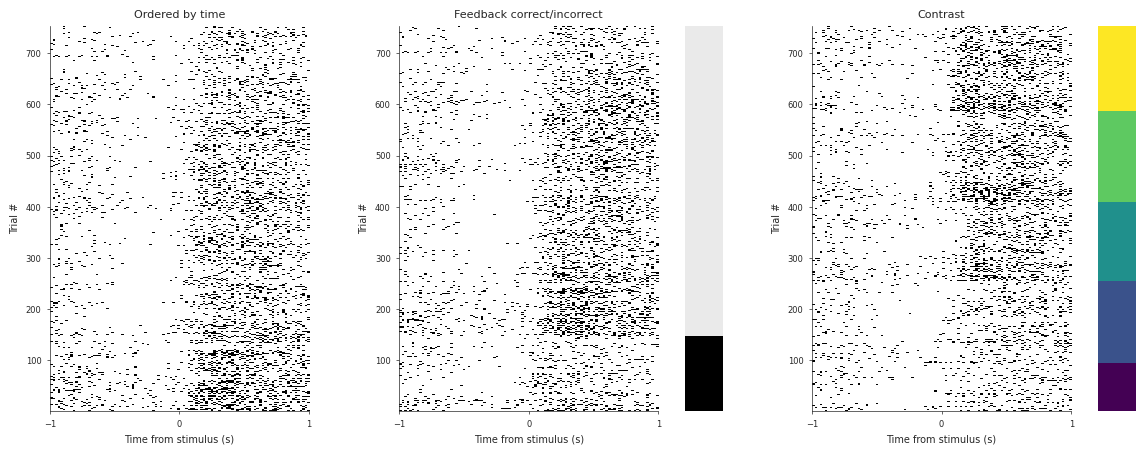

In [ ]:
ic = 6  # selected cluster

# Here we create a figure with axes for the raster and also for behaviour conditions
fig, ax = plt.subplots(ncols=7, gridspec_kw={'width_ratios': [7, 1, 7, 1, 1, 7, 1], 'hspace': 0}, figsize=(14, 5))

# those keyword arguments will be passed to all matshow raster calls
mshow_kwargs = dict(extent=[event_window[0], event_window[1], 1, sl.trials.shape[0]], vmin=0, vmax=1)

# for the left plot we keep the raster sorted in time
ax[0].matshow(psths[ic, :, :].T, aspect='auto', cmap='Greys', origin='lower', **mshow_kwargs)

# the middle plot will have the raster sorted by outcome, and we annotate the outcome as a sidebar
iordre = np.lexsort([sl.trials['feedbackType'].to_numpy()])
ax[2].matshow(psths[ic, :, iordre], aspect='auto', cmap='Greys', origin='lower', **mshow_kwargs)
ax[3].matshow(np.atleast_2d(sl.trials['feedbackType'].to_numpy()[iordre]).T, aspect='auto', cmap='Greys_r', origin='lower',  vmin=-.1, vmax=1.2)

# the right plot will have the raster sorted by contrast, and we annotate the contrast as a sidebar
iordre = np.lexsort([ sl.trials['ucontrast'].to_numpy()])
ax[5].matshow(psths[ic, :, iordre], aspect='auto', cmap='Greys', origin='lower', **mshow_kwargs)
_, uc = np.unique(sl.trials['ucontrast'].to_numpy()[iordre], return_inverse=True)
ax[6].matshow(np.atleast_2d(uc).T, aspect='auto', cmap='viridis', origin='lower')

# label the axis and other cosmetic calls
ax[0].set(xlabel='Time from stimulus (s)', ylabel='Trial #', title='Ordered by time')
ax[2].set(xlabel='Time from stimulus (s)', ylabel='Trial #', title='Feedback correct/incorrect')
ax[5].set(xlabel='Time from stimulus (s)', ylabel='Trial #', title='Contrast')
_ = [ax[i].axis('off') for i in [1, 3, 4, 6]]
_ = [ax[i].xaxis.set_ticks_position('bottom') for i in [0, 2, 5]]


Interesting patterns emerge depending on how we sort the data:


*  by time (ie. unsorted), here we can hypothesize about engagement and satiety as there is a slight decay over time
*  by feedback outcome: correct / incorrect: the cell responds more to correct trials
* by contrast value 0%, 6.25%, 12.5% 25% and 100%: the cell responds more to higher contrasts

## Display the Corresponding PSTHs

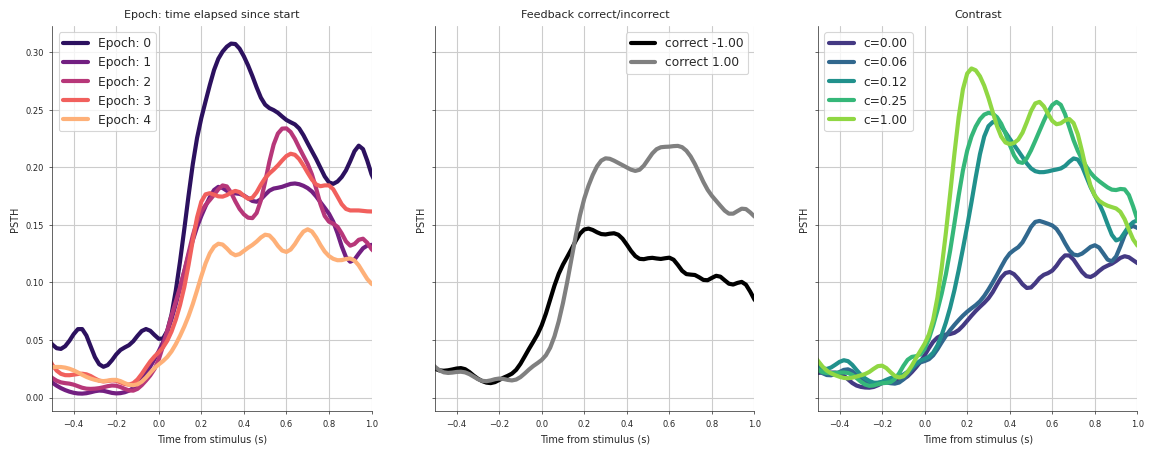

In [ ]:
# we will display the corresponding PSTHs for the rasters above
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=[14, 5])
contrasts = np.sort(sl.trials['ucontrast'].unique())
colors = sns.color_palette("viridis", n_colors=contrasts.shape[0])
contrast_colors = dict(zip(contrasts, colors))
sigma_smooth = 2
ax_set_kwargs = dict(xlabel='Time from stimulus (s)', xlim=[-0.5, 1])

# For the first, we will aggregate per "epochs", quantiles of time elapsed since session start
n_epoch = 5
epoch_colors = sns.color_palette('magma', n_colors=n_epoch)
sl.trials['epoch'] = pd.qcut(sl.trials['intervals_0'], q=n_epoch, labels=np.arange(n_epoch))
for epoch, trials in sl.trials.groupby("epoch",  observed=True):
    spikes_bin = np.sum(psths[ic, :, trials.index.values], axis=0) / trials.shape[0]
    spikes_bin = scipy.ndimage.gaussian_filter1d(spikes_bin, sigma_smooth, mode='reflect')
    ax[0].plot(tscale, spikes_bin, lw=3, color=epoch_colors[epoch], label=f"Epoch: {epoch}")
ax[0].legend()
ax[0].grid(True)
ax[0].set(ylabel='PSTH', title='Epoch: time elapsed since start', **ax_set_kwargs)

# The middle plot is the feedback outcome, correct / incorrect
for outcome, trials in sl.trials.groupby("feedbackType"):
    spikes_bin = np.sum(psths[ic, :, trials.index.values], axis=0) / trials.shape[0]
    spikes_bin = scipy.ndimage.gaussian_filter1d(spikes_bin, sigma_smooth, mode='reflect')
    ax[1].plot(tscale, spikes_bin, color='gray' if outcome == 1 else'black', lw=3, label=f"correct {outcome:.2f}")
ax[1].legend()
ax[1].grid(True)
ax[1].set(ylabel='PSTH', title='Feedback correct/incorrect', **ax_set_kwargs)

# The right plot is the contrast plot
for contrast, trials in sl.trials.groupby("ucontrast"):
    spikes_bin = np.sum(psths[ic, :, trials.index.values], axis=0) / trials.shape[0]
    spikes_bin = scipy.ndimage.gaussian_filter1d(spikes_bin, sigma_smooth, mode='reflect')
    ax[2].plot(tscale, spikes_bin, color=contrast_colors[contrast], lw=3, label=f"c={contrast:.2f}")
ax[2].legend()
ax[2].grid(True)
_ = ax[2].set(ylabel='PSTH', title='Contrast', **ax_set_kwargs)



# Multi-animal population analysis
We want to combine neural activity measured in different animals. Because neurons for each animal are recorded in a unique session, we can not simply concatenate the units. But we can concatenate PSTHs, so we will extract PSTHs for all units in a brain region of interest from all animals that contain cells from this brain region, compute the PSTHs and concatenate them along the 'unit' dimension.

First, we want ot get all pids for recordings that have an insertion our brain area of interest.

In [ ]:
# first get all recordings that have units in brain region of choice
brain_region = "SNc"
units_df_ = units_df.loc[units_df["Beryl"] == brain_region]
pids = units_df_["pid"].unique()
print(f"{len(pids)} recordings found for brain brain_region {brain_region}")

# just a safety block to prevent you from downloading too much data in the context of this tutorial.
n_cap = 3
if len(pids) > n_cap:
    print(f"only taking {n_cap} recordings into account")
    pids = pids[:n_cap]

2 recordings found for brain brain_region SNc


Then, we load the spikes for these recordings. Note that we are subselecting "good units" only. See our [spike sorting white paper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522) for tetails


In [ ]:
# we define a helper function that loads
def load_spikes(pid: str, one: ONE, brain_region: str, brain_regions: BrainRegions) -> nap.TsGroup:
    """for a given pid, load good spikes spikes as a pynapple TsGroup.

    Args:
        pid (str): the pid of the insertion
        one (ONE): one instance
        brain_area (str): the brain area of interest

    Returns:
        nap.TsGroup: _description_
    """

    # eid, pname = one.pid2eid(pid)
    eid, pname = one.pid2eid(pid)

    # 1) get spikes via the spike sorting loader
    spike_sorting_loader = SpikeSortingLoader(pid=pid, one=one)
    spikes, clusters, channels = spike_sorting_loader.load_spike_sorting(good_units=True)

    # 2) merge clusters to have the column "acronym" available, good only
    clusters_ = spike_sorting_loader.merge_clusters(spikes, clusters, channels)
    clusters_df = pd.DataFrame(clusters_).query('label == 1')

    # 3) subset to good spikes only, and only brain area of interest
    atlas_ids = regions.descendants(regions.acronym2id(brain_region))['id']
    clusters_df = clusters_df.loc[clusters_df['atlas_id'].isin(atlas_ids)]

    # 4) pack everything into a pynapple object
    units = {}
    for u in clusters_df.index:
        units[u] = nap.Ts(t=spikes["times"][spikes["clusters"] == u])

    return nap.TsGroup(units)

from iblatlas.atlas import BrainRegions
regions = BrainRegions()

# here we load the spikes
units = {}
for pid in pids:
    units[pid] = load_spikes(pid, one, brain_region, regions)
    print(f"{len(units[pid])} cells from recording {pid}")


(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe01/pykilosort/#2024-05-06#/passingSpikes.table.pqt: 100%|██████████| 360M/360M [00:02<00:00, 132MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe01/pykilosort/#2024-05-06#/clusters.channels.npy: 100%|██████████| 4.79k/4.79k [00:00<00:00, 38.7kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe01/pykilosort/#2024-05-06#/clusters.depths.npy: 100%|██████████| 2.46k/2.46k [00:00<00:00, 24.9kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe01/pykilosort/#2024-05-06#/clusters.metrics.pqt: 100%|██████████| 86.6k/86.6k [00:00<00:00, 467kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/probe01/pykilosort/#2024-05-06#/cluste

21 cells from recording 18be19f9-6ca5-4fc8-9220-ba43c3e75905


(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-11/001/alf/probe00/pykilosort/#2024-05-06#/passingSpikes.table.pqt: 100%|██████████| 146M/146M [00:01<00:00, 92.4MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-11/001/alf/probe00/pykilosort/#2024-05-06#/clusters.channels.npy: 100%|██████████| 7.00k/7.00k [00:00<00:00, 64.5kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-11/001/alf/probe00/pykilosort/#2024-05-06#/clusters.depths.npy: 100%|██████████| 3.56k/3.56k [00:00<00:00, 27.1kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-11/001/alf/probe00/pykilosort/#2024-05-06#/clusters.metrics.pqt: 100%|██████████| 119k/119k [00:00<00:00, 404kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-11/001/alf/probe00/pykilosort/#2024-05-0

6 cells from recording 96c816ad-9a48-46a4-8a84-9a73cc153d69


We will do the same with the trials tables, as they contain the information on where to slice the spike trains in time

In [ ]:
# getting the trials tables for each pid
trials = {}
for pid in pids:
    eid, _ = one.pid2eid(pid)

    session_loader = SessionLoader(eid=eid, one=one)
    session_loader.load_trials()
    trials_ = session_loader.trials

    # add here some useful columns
    # one column contrast, signed and unsigned
    trials_["contrast"] = -1 * trials_["contrastLeft"]
    ix = trials_["contrastLeft"].isna()
    trials_.loc[ix, "contrast"] = trials_.loc[ix, "contrastRight"]
    trials_["ucontrast"] = np.abs(trials_["contrast"])

    trials[pid] = trials_


(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.17k/4.17k [00:00<00:00, 25.3kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.17k/4.17k [00:00<00:00, 40.5kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-45/2021-07-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 43.1k/43.1k [00:00<00:00, 330kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-11/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.79k/3.79k [00:00<00:00, 31.3kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0020/2022-05-11/001/alf/_ibl_trials.table.pqt: 100%|██████████| 40.1k/40.1k [00:00<00:00, 330kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbr

In [ ]:
# the output is a matrix
# time x cell, and as a third is condition
# hence can be concatenated along the cell dimensions
def calculate_psths_for_conditions(
    units: nap.TsdFrame,
    trials: pd.DataFrame,
    tvec: np.ndarray,
    align_events: np.ndarray,
    split_by: str,
    n_smooth: int = 3,
) -> dict:
    """this function co

    Args:
        units (nap.TsdFrame): the units
        trials (pd.DataFrame): trials table
        tvec (np.ndarray): the time vector for the psth
        align_events (np.ndarray): build psths for these events
        split_by (str): split data by these conditions

    Returns:
        dict: a dictionary with (condition_a, conditionb_, align_event) as keys,
        condition_a/b are all combinations of split_by that are present in the data.
        values of the dict are average firing rate per condition stored as
        np.dnarrays of shape (n_time_samples x n_cells)

    """

    # time basis of the PSTH
    dt = np.median(np.diff(tvec))
    window = (tvec[0], tvec[-1]+dt)

    # iterate over all conditions
    psths = {}
    for i, (split_keys, trials_sel) in enumerate(trials.groupby(split_by)):
        for j, align_event in enumerate(align_events):
            align_times = nap.Ts(trials_sel[align_event].values)
            spikes_bin = np.zeros((tvec.shape[0], len(units)))

            for i, unit_ix in enumerate(units):
                # 1) compute psth
                peri = nap.compute_perievent(units[unit_ix], align_times, window)

                # 2) spike count to firing rate
                peri_count = peri.count(dt) / dt

                # 3) average across trials in condition
                spikes_bin_ = np.average(peri_count.values, axis=1)

                # 4) optional smoothing (helpful for conditions that don't have many trials)
                if n_smooth is not None:
                    # simple convolution with a boxcar filter
                    spikes_bin_ = np.convolve(
                        spikes_bin_, np.ones(n_smooth) / n_smooth, mode="same"
                    )
                    # edge artifact
                    spikes_bin_[: int(n_smooth / 2)] = np.nan
                    spikes_bin_[-int(n_smooth / 2) :] = np.nan

                spikes_bin[:, i] = spikes_bin_

            psths[(*split_keys, align_event)] = spikes_bin

    return psths


In [ ]:
# psth parameters
dt = 0.05
window = (-1, 1)
tvec = np.arange(*window, dt)

# psths will be calculated aligned to these events
align_events = ["stimOn_times", "firstMovement_times", "feedback_times"]

# select a split
# split_by = ["feedbackType", "ucontrast"]
split_by = ["feedbackType", "choice"]

psths_ = {}
for pid in tqdm(pids):
    trials_ = trials[pid]
    units_ = units[pid]
    psths_[pid] = calculate_psths_for_conditions(
        units_, trials_, tvec, align_events, split_by
    )

# and combine them
# we can only combine psths from session where there were trials with the conditions
# hence we need to find the set of valid conditions
conditions = []
for pid in pids:
    conditions.append(set(psths_[pid].keys()))
conditions = set.intersection(*conditions)

psths = {}
for condition in conditions:
    psths[condition] = np.concatenate(
        [psths_[pid][condition] for pid in pids], axis=1
    )

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pynapple/core/time_index.py:109: UserWarning: timestamps are not sorted
  warn("timestamps are not sorted", UserWarning)
/usr/local/lib/python3.11/dist-packages/pynapple/core/time_index.py:109: UserWarning: timestamps are not sorted
  warn("timestamps are not sorted", UserWarning)
 50%|█████     | 1/2 [00:08<00:08,  8.26s/it]/usr/local/lib/python3.11/dist-packages/pynapple/core/time_index.py:109: UserWarning: timestamps are not sorted
  warn("timestamps are not sorted", UserWarning)
/usr/local/lib/python3.11/dist-packages/pynapple/core/time_index.py:109: UserWarning: timestamps are not sorted
  warn("timestamps are not sorted", UserWarning)
100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


Text(0.5, 0.98, 'SNc activity aligned on feedback_times')

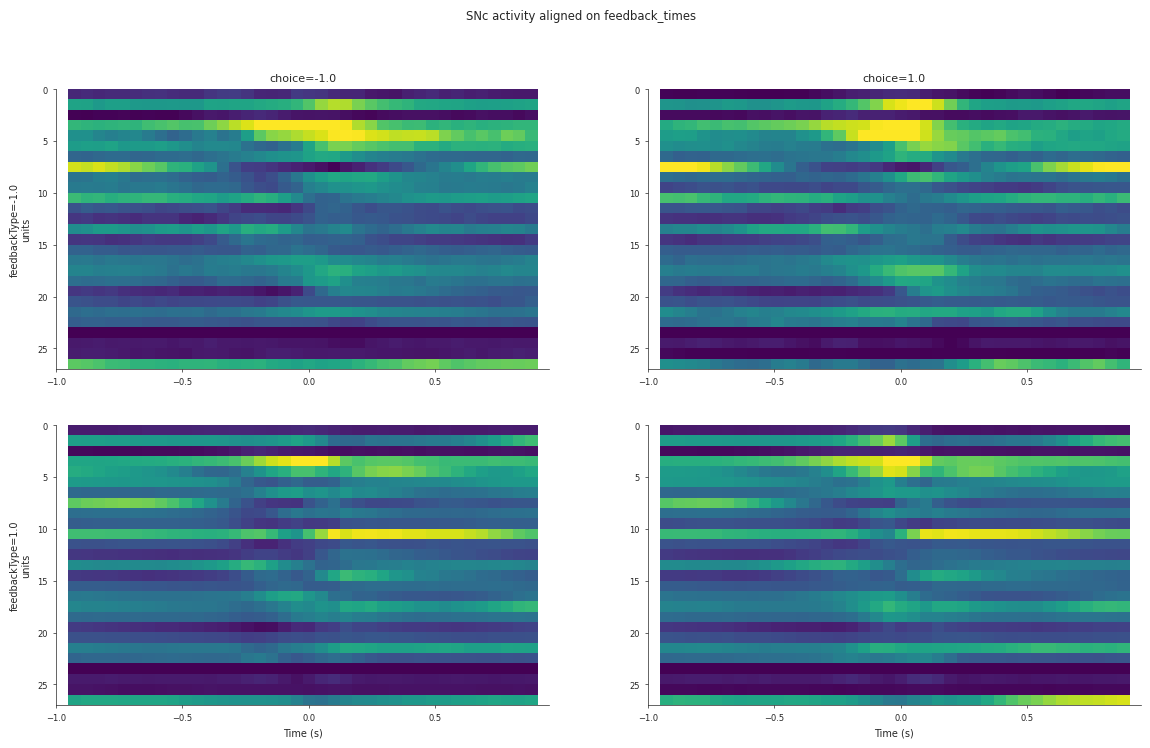

In [ ]:
align_event = "feedback_times"

n_units = sum([len(u) for k, u in units.items()])
extent = (tvec[0], tvec[-1], n_units, 0)
kwargs = dict(vmin=0, vmax=100, extent=extent, cmap='viridis')

conditions_df = pd.DataFrame(psths.keys(), columns=(*split_by, "align_event"))

# for plotting on a grid of unkown size
cond_x = np.sort(conditions_df[split_by[0]].unique())
cond_y = np.sort(conditions_df[split_by[1]].unique())

fig, axes = plt.subplots(nrows=len(cond_x), ncols=len(cond_y), figsize=[14,8])

for i, cond_a in enumerate(cond_x):
    for j, cond_b in enumerate(cond_y):
        try:
            axes[i, j].matshow(psths[(cond_a, cond_b, align_event)].T, **kwargs)
        except KeyError:
            continue

for ax in axes.flatten():
    ax.set_aspect("auto")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_ticks_position('bottom')

for i, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(f"{split_by[0]}={cond_x[i]}\nunits")

for i, ax in enumerate(axes[0, :]):
    ax.set_title(f"{split_by[1]}={cond_y[i]}")

for i, ax in enumerate(axes[-1,:]):
    ax.set_xlabel('Time (s)')

fig.suptitle(f"{brain_region} activity aligned on {align_event}")


In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px

align_event = "firstMovement_times"
align_event = "feedback_times"
align_event = "stimOn_times"

# cells are features
conditions_df = pd.DataFrame(psths.keys(), columns=(*split_by, "align_event"))
_conditions = conditions_df.groupby("align_event").get_group(align_event).values

# convert to 2d tuple
_conditions = tuple(tuple(row) for row in _conditions)

# combinding into a large matrix for PCA
# concatenate along the time axis. samples are time points, features are cells
X = np.concatenate([psths[cond] for cond in _conditions], axis=0)

# drop nans for pca (those were introduced by smoothing)
X = X[~np.any(np.isnan(X), axis=1)]

# compute the PCA (dimensionality reduction)
pca = PCA(n_components=3)
Xt = pca.fit_transform(X)

# split again into the indivdual conditions
psth_pca = dict(zip(_conditions, np.split(Xt, len(_conditions), axis=0)))

# gather the data for a 3d plot
dfs = []
for cond in _conditions:
    contrast, outcome, _ = cond
    df = pd.DataFrame(psth_pca[cond], columns=['x','y','z'])
    label = f"{split_by[0]}={cond[0]},{split_by[1]}={cond[1]}"
    df['cond'] = label
    dfs.append(df)

df = pd.concat(dfs, axis=0)

# 3d plot using plotly
fig = px.line_3d(df, x='x',y='y',z='z',color='cond')
fig.layout.scene.camera.projection.type = "orthographic"
fig.layout.dragmode = "turntable"
fig.show()